In [121]:
# Import Libraries
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import yfinance as yf

In [122]:
CRYPTO_CURRENCY = 'BTC'
AGAINST_CURRENCY = 'INR'
END = dt.datetime.now()
START = pd.to_datetime(END) - pd.DateOffset(days=2) #dt.datetime(2023,4,1)
print(START)
PERIOD = '1d'
INERVAL = "5m"

2023-05-15 02:24:58.741409


In [123]:
# Read Data
data = yf.download(f"{CRYPTO_CURRENCY}-{AGAINST_CURRENCY}", start=START, end=END, period=PERIOD, interval=INERVAL)

[*********************100%***********************]  1 of 1 completed


In [124]:
# Data Prepration and Analysis
data.tail()

Open        High         Low       Close   
Datetime                                                                    
2023-05-16 20:30:00+00:00  2217530.00  2219390.50  2217530.00  2218882.00  \
2023-05-16 20:35:00+00:00  2218978.50  2220552.75  2218978.50  2219520.50   
2023-05-16 20:40:00+00:00  2220209.25  2220209.25  2219264.25  2219834.00   
2023-05-16 20:45:00+00:00  2220500.75  2221176.00  2220500.75  2220894.25   
2023-05-16 20:50:00+00:00  2219509.25  2219509.25  2218862.50  2219265.25   

                            Adj Close      Volume  
Datetime                                           
2023-05-16 20:30:00+00:00  2218882.00   677445632  
2023-05-16 20:35:00+00:00  2219520.50  1937506304  
2023-05-16 20:40:00+00:00  2219834.00   440270848  
2023-05-16 20:45:00+00:00  2220894.25   337903616  
2023-05-16 20:50:00+00:00  2219265.25   646709248

In [125]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
#prediction_days = 60 # for 1 day interval prediction
prediction_days = 288  # 1 day period with 5-minute interval (24 hours * 60 minutes / 5 minutes)
# future day = 30 # to predict for next 30th day
x_train, y_train = [], []
for x in range(prediction_days, len(scaled_data)): # for future days -> len(scaled_data) - future day
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [126]:
# Create Neural Network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
7/7 [==============================] - 9s 284ms/step - loss: 0.0234
Epoch 2/25
7/7 [==============================] - 2s 282ms/step - loss: 0.0096
Epoch 3/25
7/7 [==============================] - 2s 278ms/step - loss: 0.0089
Epoch 4/25
7/7 [==============================] - 2s 274ms/step - loss: 0.0078
Epoch 5/25
7/7 [==============================] - 2s 302ms/step - loss: 0.0062
Epoch 6/25
7/7 [==============================] - 2s 309ms/step - loss: 0.0071
Epoch 7/25
7/7 [==============================] - 2s 300ms/step - loss: 0.0060
Epoch 8/25
7/7 [==============================] - 2s 297ms/step - loss: 0.0054
Epoch 9/25
7/7 [==============================] - 2s 294ms/step - loss: 0.0053
Epoch 10/25
7/7 [==============================] - 2s 292ms/step - loss: 0.0048
Epoch 11/25
7/7 [==============================] - 2s 295ms/step - loss: 0.0046
Epoch 12/25
7/7 [==============================] - 2s 294ms/step - loss: 0.0045
Epoch 13/25
7/7 [==============================] 

[*********************100%***********************]  1 of 1 completed
16/16 [==============================] - 3s 92ms/step


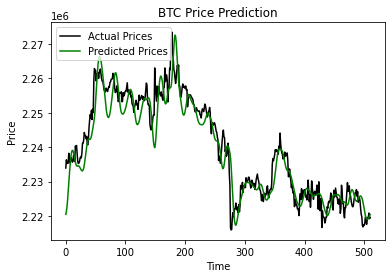

In [127]:
# test model
test_data = yf.download("BTC-INR", start=START, end=END, period=PERIOD, interval=INERVAL)
actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f"{CRYPTO_CURRENCY} Price Prediction")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [128]:
# Predict Next Day
real_data = [model_inputs[len(model_inputs)+1 - prediction_days: len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 1s 1s/step
[[2220966.]]


In [129]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
r2 = r2_score(actual_prices, prediction_prices)
r2

0.8892282985535589

In [132]:
 # Get the last predicted price and the previous actual price
last_predicted_price = prediction_prices[-1]
previous_actual_price = actual_prices[-2]
latest_actual_price = actual_prices[-1]

# Calculate the current profit/loss percentage
current_profit = ((latest_actual_price - previous_actual_price) / previous_actual_price) * 100

# Determine the market direction
if last_predicted_price < previous_actual_price: #and talib.RSI(actual_prices) > RSI_UPPER_LIMIT:
    market_direction = "Market is likely to go down. Place SELL Order!!"
    print(market_direction)
elif last_predicted_price > previous_actual_price:# and talib.RSI(actual_prices) < RSI_LOWER_LIMIT:
    market_direction = "Market is likely to go up. Place BUY Order!!"
    print(market_direction)
else:
    market_direction = "Market is likely to remain unchanged."
    print(market_direction)

print(f"Current Profit/Loss: {current_profit:.2f}%")

# Check if profit limit or stop loss is achieved
# if current_profit >= profit_limit:
#     print("Profit limit achieved. Exiting program.")
# elif current_profit <= -stop_loss:
#     print("Stop loss achieved. Exiting program.")

Market is likely to go up. Place BUY Order!!
Current Profit/Loss: 0.02%
